In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
import xml.etree.ElementTree as ET
import cv2
from sklearn.model_selection import train_test_split

# -----------------------------
# 1. Paths
# -----------------------------
train_dir = "Downloads/Object detection dataset/train/train"
test_dir  = "Downloads/Object detection dataset/test/test"

# -----------------------------
# 2. Parse VOC Annotations (example)
# -----------------------------
def load_data(img_dir):
    images = []
    boxes = []
    labels = []

    for file in os.listdir(img_dir):
        if file.endswith(".xml"):
            xml_path = os.path.join(img_dir, file)
            tree = ET.parse(xml_path)
            root = tree.getroot()

            # Image path
            img_file = root.find("filename").text
            img_path = os.path.join(img_dir, img_file)

            if not os.path.exists(img_path):
                continue

            img = cv2.imread(img_path)
            img = cv2.resize(img, (224, 224))  # Resize for VGG16
            images.append(img)

            # Bounding box and label (for simplicity, take first object only)
            obj = root.find("object")
            label = obj.find("name").text
            labels.append(label)

            bndbox = obj.find("bndbox")
            xmin = int(bndbox.find("xmin").text)
            ymin = int(bndbox.find("ymin").text)
            xmax = int(bndbox.find("xmax").text)
            ymax = int(bndbox.find("ymax").text)
            boxes.append([xmin, ymin, xmax, ymax])

    return np.array(images), np.array(boxes), np.array(labels)

X, y_boxes, y_labels = load_data(train_dir)

# Normalize images
X = X / 255.0

# Encode labels
label_encoder = {label: idx for idx, label in enumerate(np.unique(y_labels))}
y_labels = np.array([label_encoder[l] for l in y_labels])

# -----------------------------
# 3. Build model using VGG16
# -----------------------------
base_model = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
x = Flatten()(base_model.output)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.5)(x)

# Two heads: one for classification, one for bounding box regression
class_output = Dense(len(label_encoder), activation="softmax", name="class_output")(x)
bbox_output  = Dense(4, activation="linear", name="bbox_output")(x)

model = Model(inputs=base_model.input, outputs=[class_output, bbox_output])
model.compile(optimizer="adam",
              loss={"class_output": "sparse_categorical_crossentropy",
                    "bbox_output": "mse"},
              metrics={"class_output": "accuracy"})

model.summary()

# -----------------------------
# 4. Train/Test split
# -----------------------------
X_train, X_val, y_labels_train, y_labels_val, y_boxes_train, y_boxes_val = train_test_split(
    X, y_labels, y_boxes, test_size=0.2, random_state=42
)

# -----------------------------
# 5. Train
# -----------------------------
history = model.fit(
    X_train,
    {"class_output": y_labels_train, "bbox_output": y_boxes_train},
    validation_data=(X_val, {"class_output": y_labels_val, "bbox_output": y_boxes_val}),
    epochs=2,
    batch_size=8
)


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 224, 224, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 224, 224, 64  36928       ['block1_conv1[0][0]']           
                                )                                                             

2/2 [==============================] - 9s 4s/step


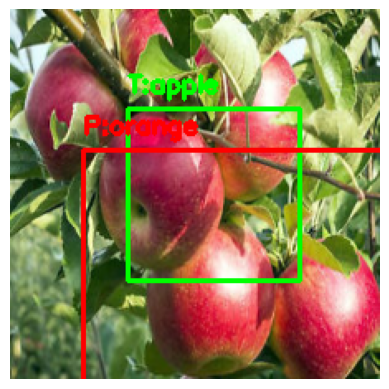

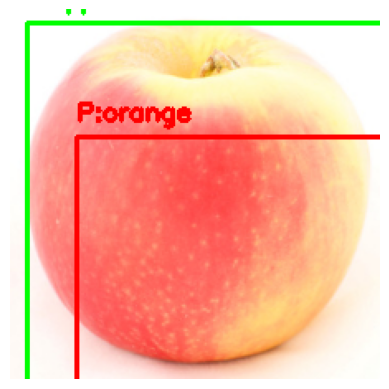

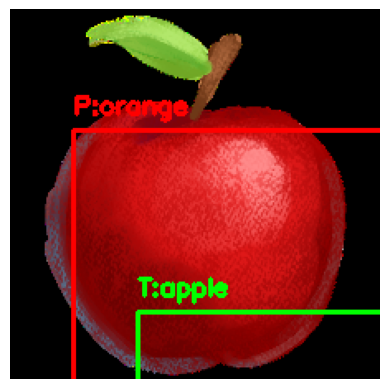

In [4]:
import matplotlib.pyplot as plt
import cv2
import numpy as np

# Load test data
X_test, y_boxes_test, y_labels_test = load_data(test_dir)
X_test = X_test / 255.0

# Predict
pred_classes, pred_bboxes = model.predict(X_test)
pred_classes = np.argmax(pred_classes, axis=1)

# Map index to label
idx_to_label = {v: k for k, v in label_encoder.items()}

# Show 3 predictions
for i in range(3):
    img = (X_test[i] * 255).astype(np.uint8).copy()
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # True box (green)
    x1, y1, x2, y2 = y_boxes_test[i]
    cv2.rectangle(img, (x1,y1), (x2,y2), (0,255,0), 2)

    # Pred box (red)
    px1, py1, px2, py2 = pred_bboxes[i].astype(int)
    cv2.rectangle(img, (px1,py1), (px2,py2), (255,0,0), 2)

    # Labels
    true_label = y_labels_test[i]   # already string (e.g., "apple")
    pred_label = idx_to_label[pred_classes[i]]

    cv2.putText(img, f"T:{true_label}", (x1, y1-10),
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,255,0), 2)
    cv2.putText(img, f"P:{pred_label}", (px1, py1-10),
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,0,0), 2)

    plt.imshow(img)
    plt.axis("off")
    plt.show()
